### Modeling DAQUAR

### Setup Environment

In [17]:
import pandas as pd
import os

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

# Function to train classic ML model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

In [2]:
PATH = 'Embeddings/daquar/'
COLUMN = 'embeddings'

In [3]:
text_path, images_path = os.listdir(PATH)

## Get data

### Text

In [4]:
text = pd.read_csv(os.path.join(PATH, text_path))
text

,question,image_id,answer,split,embeddings
0,what is on the right side of the black telepho...,image3,desk,train,"[1.939268708229065, -3.4391133785247803, 0.621..."
1,what is in front of the white door on the left...,image3,telephone,train,"[2.3296871185302734, -2.358933448791504, 0.505..."
2,what is on the desk in the image3 ?,image3,"book, scissor, papers, tape_dispenser",train,"[2.674177885055542, -2.5977489948272705, 0.902..."
3,what is the largest brown objects in this imag...,image3,carton,train,"[0.8832639455795288, -3.125410795211792, 0.978..."
4,what color is the chair in front of the white ...,image3,red,train,"[2.274566411972046, -2.7862119674682617, 0.255..."
...,...,...,...,...,...
12463,what is found below the chandelier in the imag...,image1448,table,test,"[2.5518476963043213, -1.2780189514160156, 0.16..."
12464,what is on the floor in the image1449 ?,image1449,rug,test,"[2.225504159927368, -2.0832605361938477, 0.602..."
12465,what are around dining table in the image1449 ?,image1449,chair,test,"[2.3164994716644287, -1.3577170372009277, 0.70..."
12466,what is at the opposite side of the dining tab...,image1449,decoration_item,test,"[2.782546043395996, -1.9179561138153076, -0.22..."


### Images

In [5]:
images = pd.read_csv(os.path.join(PATH, images_path))
images.head()

,ImageName,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,image594.png,-1.025568,-1.905249,1.803225,0.463002,-1.262579,-0.112514,-3.162845,2.348077,-0.479168,...,2.270620,-1.028574,-0.448215,1.438546,-1.028833,-1.235231,-0.655922,-1.834680,0.117828,-0.918517
1,image203.png,3.611837,-1.924588,1.274643,1.706902,0.174405,-0.214314,3.158729,1.742178,-0.334743,...,1.011012,2.300838,-1.185590,-2.842626,-0.679292,1.676797,-1.229288,-1.204887,1.745926,2.434615
2,image168.png,1.626282,0.947323,2.461556,-0.322470,-0.143544,-1.234781,2.424111,-2.791227,3.200879,...,0.911699,0.956678,-0.953489,1.423617,0.874067,-2.416704,-0.029765,-1.183748,-2.286630,0.289733
3,image1384.png,2.478895,0.788063,2.516460,0.889721,-0.528015,-1.972060,0.100951,0.765253,1.176786,...,-0.701619,-0.601509,2.455005,0.982928,-0.472275,-1.062110,-0.819126,1.281750,1.627683,1.166322
4,image491.png,-0.675730,1.637991,-0.266713,-0.906799,2.069989,1.631083,0.525139,-1.129734,-0.700581,...,-1.553325,1.181338,-0.344635,0.922044,-2.769332,5.036960,-1.318768,0.651291,0.880518,-1.872785


### Merge and preprocess the datasets

In [6]:
def process_embeddings(df, col_name):
    # Step 1: Convert the values in the column to lists
    df[col_name] = df[col_name].apply(eval)

    # Step 2-4: Extract values from lists and create new columns
    embeddings_df = pd.DataFrame(df[col_name].to_list(), columns=[f"text_{i+1}" for i in range(df[col_name].str.len().max())])
    df = pd.concat([df, embeddings_df], axis=1)

    # Step 5: Remove the original "embeddings" column
    df = df.drop(columns=[col_name])

    return df

In [7]:
def rename_image_embeddings(df):
    
    df.columns = [f'image_{int(col)}' if col.isdigit() else col for col in df.columns]

    return df

In [8]:
# Preprocess and merge the dataframes
def preprocess_data(text_data, image_data, text_id="image_id", image_id="ImageName", embeddings_col = 'embeddings'):
    
    text_data = process_embeddings(text_data, embeddings_col)
    image_data = rename_image_embeddings(image_data)
    
    # Remove file extension from image_id
    text_data[text_id] = text_data[text_id].apply(lambda x: x.split('.')[0])
    image_data[image_id] = image_data[image_id].apply(lambda x: x.split('.')[0])

    # Merge dataframes using image_id
    df = pd.merge(text_data, image_data, left_on=text_id, right_on=image_id)

    # Drop unnecessary columns
    df.drop([image_id, text_id], axis=1, inplace=True)

    return df

In [9]:
df = preprocess_data(text, images)
df.head()

,question,answer,split,text_1,text_2,text_3,text_4,text_5,text_6,text_7,...,image_758,image_759,image_760,image_761,image_762,image_763,image_764,image_765,image_766,image_767
0,what is on the right side of the black telepho...,desk,train,1.939269,-3.439113,0.621131,1.283934,0.952163,0.797746,0.987881,...,0.122119,-1.201706,-1.186273,2.6443,-2.110871,-1.375333,0.435534,0.528984,-0.459251,-0.830088
1,what is in front of the white door on the left...,telephone,train,2.329687,-2.358933,0.505093,0.432262,0.869567,0.299435,0.114759,...,0.122119,-1.201706,-1.186273,2.6443,-2.110871,-1.375333,0.435534,0.528984,-0.459251,-0.830088
2,what is on the desk in the image3 ?,"book, scissor, papers, tape_dispenser",train,2.674178,-2.597749,0.902279,-0.508954,0.004625,-0.268740,0.338454,...,0.122119,-1.201706,-1.186273,2.6443,-2.110871,-1.375333,0.435534,0.528984,-0.459251,-0.830088
3,what is the largest brown objects in this imag...,carton,train,0.883264,-3.125411,0.978738,-1.510595,2.501983,1.507551,-1.273407,...,0.122119,-1.201706,-1.186273,2.6443,-2.110871,-1.375333,0.435534,0.528984,-0.459251,-0.830088
4,what color is the chair in front of the white ...,red,train,2.274566,-2.786212,0.255177,1.062328,0.280255,1.321580,-0.239668,...,0.122119,-1.201706,-1.186273,2.6443,-2.110871,-1.375333,0.435534,0.528984,-0.459251,-0.830088


## Data Perparation

In [31]:
# Function to split the data into train and test
def split_data(df):
    train_df = df[df['split'] == 'train']
    test_df = df[df['split'] == 'test']
    
    print("Train Shape:", train_df.shape)
    print("Test Shape:", test_df.shape)
    return train_df, test_df

# Function to process text labels and one-hot encode them
def process_labels(df, col='answer', mlb=None, train_columns=None):
    if mlb is None:
        mlb = MultiLabelBinarizer()
        labels = df[col].apply(lambda x: set(x.split(', ')))
        one_hot_labels = pd.DataFrame(mlb.fit_transform(labels), columns=mlb.classes_)
        # Save the columns from the training set
        train_columns = one_hot_labels.columns
        
        return one_hot_labels, mlb, train_columns

    else:
        labels = df[col].apply(lambda x: set(x.split(', ')))
        one_hot_labels = pd.DataFrame(mlb.transform(labels), columns=train_columns)
        
        return one_hot_labels

    
# Custom Dataset class for PyTorch
class VQADataset(Dataset):
    def __init__(self, df, text_cols, image_cols, label_col, mlb, train_columns):
        self.text_data = df[text_cols].values
        self.image_data = df[image_cols].values
        self.mlb = mlb
        self.train_columns = train_columns
        self.labels = process_labels(df, col=label_col, mlb=mlb, train_columns=train_columns).values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text': torch.FloatTensor(self.text_data[idx]),
            'image': torch.FloatTensor(self.image_data[idx]),
            'labels': torch.FloatTensor(self.labels[idx])
        }


# Early Fusion Model
class EarlyFusionModel(nn.Module):
    def __init__(self, text_input_size, image_input_size, output_size, hidden=[128]):
        super(EarlyFusionModel, self).__init__()
        
        output_dim = text_input_size + image_input_size
        
        # Initialize layers as an empty list
        layers = []
        
        # Add the linear layer and ReLU activation if 'hidden' is an integer
        if isinstance(hidden, int):
            layers.append(nn.Linear(output_dim, hidden))
            layers.append(nn.ReLU())
            #layers.append(nn.Dropout(p=0.2))

            output_dim = hidden
            
        # Add the linear layer and ReLU activation for each element in 'hidden' if it's a list
        elif isinstance(hidden, list):
            for h in hidden:
                layers.append(nn.Linear(output_dim, h))
                layers.append(nn.ReLU())
                #layers.append(nn.Dropout(p=0.2))
                #layers.append(nn.BatchNorm1d(h))
                output_dim = h
        
        self.fc1 = nn.Sequential(*layers)

        
        #self.fc1 = nn.Linear(text_input_size + image_input_size, hidden)
        
        self.fc2 = nn.Linear(output_dim, output_size)

    def forward(self, text, image):
        x = torch.cat((text, image), dim=1)
        #x = torch.relu(self.fc1(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Late Fusion Model
class LateFusionModel(nn.Module):
    def __init__(self, text_input_size, image_input_size, output_size, hidden_images=[64], hidden_text=[64]):
        super(LateFusionModel, self).__init__()
        
        self.text_fc, out_text = self._get_layers(text_input_size, hidden_text)
        self.image_fc, out_images = self._get_layers(image_input_size, hidden_images)
        
        #self.text_fc = nn.Linear(text_input_size, hidden_text)
        #self.image_fc = nn.Linear(image_input_size, hidden_images)
        
        
        self.fc2 = nn.Linear(out_text + out_images, output_size)
        
    def _get_layers(self, embed_dim, hidden, p=0.2):
        # Initialize layers as an empty list
        layers = []
        output_dim = embed_dim
        
        # Add the linear layer and ReLU activation if 'hidden' is an integer
        if isinstance(hidden, int):
            layers.append(nn.Linear(output_dim, hidden))
            layers.append(nn.ReLU())
            #layers.append(nn.Dropout(p=p))

            output_dim = hidden
            
        # Add the linear layer and ReLU activation for each element in 'hidden' if it's a list
        elif isinstance(hidden, list):
            for h in hidden:
                layers.append(nn.Linear(output_dim, h))
                layers.append(nn.ReLU())
                #layers.append(nn.Dropout(p=p))
                #layers.append(nn.BatchNorm1d(h))
                output_dim = h
        
        fc = nn.Sequential(*layers)
        
        return fc, output_dim

    def forward(self, text, image):
        text_output = self.text_fc(text)
        image_output = self.image_fc(image)
        #text_output = torch.relu(self.text_fc(text))
        #image_output = torch.relu(self.image_fc(image))
        x = torch.cat((text_output, image_output), dim=1)
        x = self.fc2(x)
        return x


def train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=5):
    model = LateFusionModel(text_input_size=text_input_size, image_input_size=image_input_size, output_size=output_size)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracy_list = []
    test_accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            text, image, labels = batch['text'], batch['image'], batch['labels']
            optimizer.zero_grad()
            outputs = model(text, image)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_true, y_pred = [], []
            for batch in test_loader:
                text, image, labels = batch['text'], batch['image'], batch['labels']
                outputs = model(text, image)
                preds = torch.sigmoid(outputs)
                y_true.extend(labels.numpy())
                y_pred.extend(preds.numpy())

            y_true, y_pred = np.array(y_true), np.array(y_pred)
            test_accuracy = accuracy_score(y_true, (y_pred > 0.5).astype(int))
            test_accuracy_list.append(test_accuracy)
            
            # Calculate and store train accuracy
            model.train()
            with torch.no_grad():
                train_preds = model(batch['text'], batch['image'])
                train_accuracy = accuracy_score(labels.numpy(), (torch.sigmoid(train_preds).numpy() > 0.5).astype(int))
                train_accuracy_list.append(train_accuracy)

            print(f"Epoch {epoch + 1}/{num_epochs} - Test Accuracy: {test_accuracy:.4f}")

    # Plot the accuracy
    #plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracy_list, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Function to train late fusion model (similar changes)
def train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=5):
    model = LateFusionModel(text_input_size=text_input_size, image_input_size=image_input_size, output_size=output_size)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracy_list = []
    test_accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            text, image, labels = batch['text'], batch['image'], batch['labels']
            optimizer.zero_grad()
            outputs = model(text, image)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_true, y_pred = [], []
            for batch in test_loader:
                text, image, labels = batch['text'], batch['image'], batch['labels']
                outputs = model(text, image)
                preds = torch.sigmoid(outputs)
                y_true.extend(labels.numpy())
                y_pred.extend(preds.numpy())

            y_true, y_pred = np.array(y_true), np.array(y_pred)
            test_accuracy = accuracy_score(y_true, (y_pred > 0.5).astype(int))
            test_accuracy_list.append(test_accuracy)
            
            # Calculate and store train accuracy
            model.train()
            with torch.no_grad():
                train_preds = model(batch['text'], batch['image'])
                train_accuracy = accuracy_score(labels.numpy(), (torch.sigmoid(train_preds).numpy() > 0.5).astype(int))
                train_accuracy_list.append(train_accuracy)

            print(f"Epoch {epoch + 1}/{num_epochs} - Test Accuracy: {test_accuracy:.4f}")

    # Plot the accuracy
    #plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracy_list, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Function to evaluate classic ML model
def evaluate_classic_ml_model(model_name, y_true, y_pred, train_columns):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='micro')

    print(f"{model_name} - Test Accuracy: {accuracy}")
    print(f"{model_name} - Test F1 Score: {f1}")
    
def train_classic_ml_models(train_data, test_data, train_labels, test_labels, train_columns):
    # Separate features and labels
    X_train, y_train = train_data[text_columns + image_columns], train_labels
    X_test, y_test = test_data[text_columns + image_columns], test_labels

    # Random Forest
    rf_model = OneVsRestClassifier(RandomForestClassifier())
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)

    # Logistic Regression
    lr_model = OneVsRestClassifier(LogisticRegression())
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)

    # SVM
    svm_model = OneVsRestClassifier(SVC())
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)

    # Evaluate models
    evaluate_classic_ml_model("Random Forest", y_test, rf_pred, train_columns)
    evaluate_classic_ml_model("Logistic Regression", y_test, lr_pred, train_columns)
    evaluate_classic_ml_model("SVM", y_test, svm_pred, train_columns)


In [11]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column] #[f'text_{i}']
image_columns = [column for column in df.columns if 'image' in column] #[f'image_{i}']
label_columns = 'answer'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train Shape: (6795, 4867)
Test Shape: (5673, 4867)


/home/datascience/conda/data_fusion_v0_0_1/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['13', '2163', 'back_scrubber', 'basketball', 'basketball_hoop', 'blender', 'box_of_paper', 'canister', 'cap_stand', 'cat', 'cleaner', 'clothing_hamper', 'clothing_iron', 'comb', 'cork_board', 'decorative_candle', 'dog_toy', 'door_frame', 'door_way_arch', 'drying_stand', 'duster', 'electric_box', 'electrical_outlet', 'exit_sign', 'eye_glasses', 'faucet_handle', 'file_pad', 'flask', 'food_wrapped_on_a_tray', 'furniture', 'glass_pane', 'glass_pot', 'guitar_case', 'hamburger_bun', 'hand_sanitizer_dispenser', 'hand_sculpture', 'handle', 'hanging_hooks', 'head_phone', 'head_phones', 'id_card', 'iphone', 'iron_grill', 'key', 'kitchen_items', 'measuring_cup', 'microphone_stand', 'music_stereo', 'napkin_holder', 'onion', 'orange_juicer', 'pan', 'paper_towel', 'pepper_shaker', 'piece_of_wood', 'pineapple', 'plastic_chair', 'razor', 'roll_of_paper_towels', 's

### Models

In [12]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
output_size = len(mlb.classes_)

Training Early Fusion Model:
Epoch 1/40 - Test Accuracy: 0.0180
Epoch 2/40 - Test Accuracy: 0.0293
Epoch 3/40 - Test Accuracy: 0.0418
Epoch 4/40 - Test Accuracy: 0.0423
Epoch 5/40 - Test Accuracy: 0.0603
Epoch 6/40 - Test Accuracy: 0.0585
Epoch 7/40 - Test Accuracy: 0.0747
Epoch 8/40 - Test Accuracy: 0.0929
Epoch 9/40 - Test Accuracy: 0.0910
Epoch 10/40 - Test Accuracy: 0.0989
Epoch 11/40 - Test Accuracy: 0.1036
Epoch 12/40 - Test Accuracy: 0.1042
Epoch 13/40 - Test Accuracy: 0.1109
Epoch 14/40 - Test Accuracy: 0.1075
Epoch 15/40 - Test Accuracy: 0.1155
Epoch 16/40 - Test Accuracy: 0.1133
Epoch 17/40 - Test Accuracy: 0.1109
Epoch 18/40 - Test Accuracy: 0.0968
Epoch 19/40 - Test Accuracy: 0.1125
Epoch 20/40 - Test Accuracy: 0.1170
Epoch 21/40 - Test Accuracy: 0.1259
Epoch 22/40 - Test Accuracy: 0.1220
Epoch 23/40 - Test Accuracy: 0.1167
Epoch 24/40 - Test Accuracy: 0.1297
Epoch 25/40 - Test Accuracy: 0.1243
Epoch 26/40 - Test Accuracy: 0.1165
Epoch 27/40 - Test Accuracy: 0.1280
Epoch 28

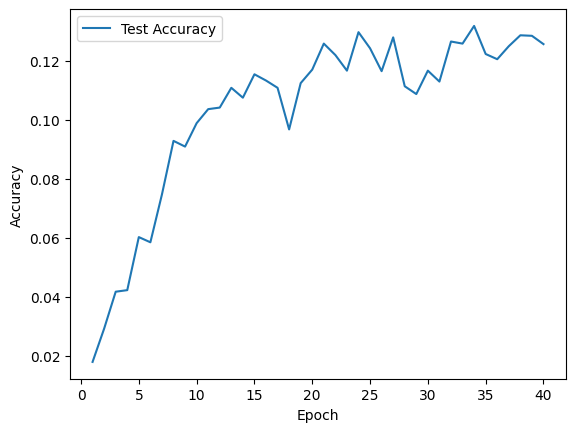

In [32]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=40)

Training Late Fusion Model:
Epoch 1/40 - Test Accuracy: 0.0194
Epoch 2/40 - Test Accuracy: 0.0340
Epoch 3/40 - Test Accuracy: 0.0497
Epoch 4/40 - Test Accuracy: 0.0774
Epoch 5/40 - Test Accuracy: 0.0628
Epoch 6/40 - Test Accuracy: 0.1014
Epoch 7/40 - Test Accuracy: 0.0777
Epoch 8/40 - Test Accuracy: 0.0966
Epoch 9/40 - Test Accuracy: 0.0922
Epoch 10/40 - Test Accuracy: 0.0897
Epoch 11/40 - Test Accuracy: 0.1028
Epoch 12/40 - Test Accuracy: 0.1216
Epoch 13/40 - Test Accuracy: 0.1121
Epoch 14/40 - Test Accuracy: 0.0952
Epoch 15/40 - Test Accuracy: 0.1059
Epoch 16/40 - Test Accuracy: 0.1190
Epoch 17/40 - Test Accuracy: 0.1165
Epoch 18/40 - Test Accuracy: 0.1086
Epoch 19/40 - Test Accuracy: 0.1144
Epoch 20/40 - Test Accuracy: 0.1065
Epoch 21/40 - Test Accuracy: 0.1186
Epoch 22/40 - Test Accuracy: 0.1167
Epoch 23/40 - Test Accuracy: 0.1218
Epoch 24/40 - Test Accuracy: 0.1294
Epoch 25/40 - Test Accuracy: 0.1165
Epoch 26/40 - Test Accuracy: 0.1260
Epoch 27/40 - Test Accuracy: 0.1230
Epoch 28/

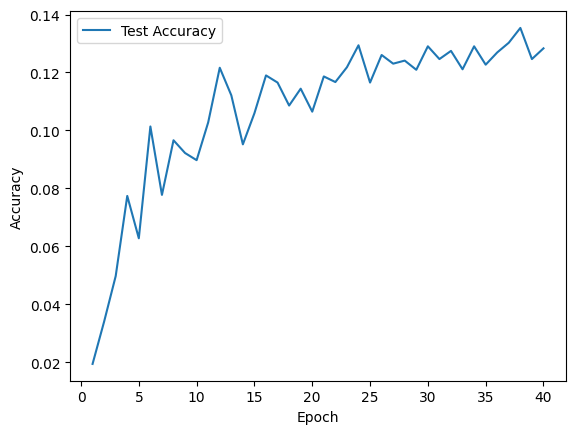

In [33]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=40)